In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import itertools
from attrbench import datasets, attribution, models
from os import path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from attrbench.evaluation.sanity_checks import model_randomisation, data_randomisation,train_with_random_labels
import torch

### perform model randomisation sanity check

In [3]:
metric = 'abs_spearman'  # one of spearman, abs_spearman, hog or ssim

device = "cuda"
dataset_name = "CIFAR10"
model_name = "resnet20"
download_dataset = False
batch_size = 16
n_batches = 3
data_root = '..\data'
normalize_attrs = False
aggregation_fn = "avg"
dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"), download=False,
                         shuffle=False, version="cifar10")

In [4]:
model_name = "resnet18"
model = models.Resnet(version=model_name, params_loc=path.join(data_root, f"models/{dataset_name}/{model_name}.pt"),
                      output_logits=True, num_classes=10)
model.to(device)
model.eval()
pass  # Prevents output from model.eval()

In [27]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

attribution_methods = {
    # "GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
    "Random": attribution.Random(**kwargs)
}


In [28]:
model_randomisation_result = model_randomisation(dataset.get_dataloader(train=False), model, attribution_methods, 
                                                 n_batches, device=device, metric=metric)
 

C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\attr\_utils\gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


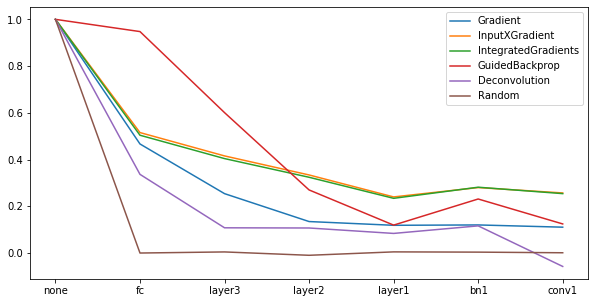

In [29]:
df = pd.DataFrame.from_dict(model_randomisation_result)
df.plot(figsize=(10,5))

### randomise labels sanity check

In [4]:
# example of random label training
rng_label_model = models.CifarResnet(version=model_name, params_loc=None,
                           num_classes=10,output_logits=False)
dataset_rng_label = datasets.Cifar(batch_size=2048, data_location=path.join(data_root, "CIFAR10"),
                                   download=False, shuffle=False, version="cifar10")
rng_dataloader = dataset_rng_label.get_dataloader(train=True)
rng_dataloader.pin_memory = True
rng_dataloader.num_workers = 4
rng = np.random.default_rng()
rng.shuffle(rng_dataloader.dataset.targets)


In [22]:
rng_label_model = train_with_random_labels(rng_label_model,rng_dataloader, lr=1e-4, epochs = 20)

epoch 0: loss: 1.7278193235397339 accuracy: 0.7258097330729166
learning rate: 1.0518935794391287e-05
epoch 1: loss: 1.7276849846045177 accuracy: 0.7259928385416666
learning rate: 2.830505468209031e-05
epoch 2: loss: 1.7274473309516907 accuracy: 0.72613525390625
learning rate: 5.252724970225042e-05
epoch 3: loss: 1.7272010445594788 accuracy: 0.7262980143229166
learning rate: 7.660623193255291e-05
epoch 4: loss: 1.7271371831496556 accuracy: 0.7264607747395834
learning rate: 9.400161224159653e-05
epoch 5: loss: 1.7274072964986165 accuracy: 0.7211100260416666
learning rate: 9.999781447238579e-05
epoch 6: loss: 1.7273499369621277 accuracy: 0.72418212890625
learning rate: 9.864024353010261e-05
epoch 7: loss: 1.7271839529275894 accuracy: 0.7218424479166666
learning rate: 9.484365770208611e-05
epoch 8: loss: 1.7267377773920696 accuracy: 0.7038981119791666
learning rate: 8.879843365491486e-05
epoch 9: loss: 1.7263891249895096 accuracy: 0.7270914713541666
learning rate: 8.08077041649713e-05
epoc

### Evaluate 

In [20]:
metric = 'abs_spearman'
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}
rng_label_attribution_methods = {
    # "GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": methods.Gradient(rng_label_model, **kwargs),
    "InputXGradient": methods.InputXGradient(rng_label_model, **kwargs),
    "IntegratedGradients": methods.IntegratedGradients(rng_label_model, **kwargs),
    "GuidedBackprop": methods.GuidedBackprop(rng_label_model, **kwargs),
    "Deconvolution": methods.Deconvolution(rng_label_model, **kwargs),
    "Random": methods.Random(**kwargs)
}

data_randomisation_result = data_randomisation(dataset.get_dataloader(train=False),
                                               attribution_methods,rng_label_attribution_methods, n_batches,
                                               device=device, metric=metric)
print(data_randomisation_result)

C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\attr\_utils\gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\axelj\Anaconda3\envs\Benchmarking\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


{'Gradient': 0.3329034685442785, 'InputXGradient': 0.33271335208628, 'IntegratedGradients': 0.3440673532781302, 'GuidedBackprop': 0.40324528857430025, 'Deconvolution': 0.05769971893455092, 'Random': -0.000694983953130399}


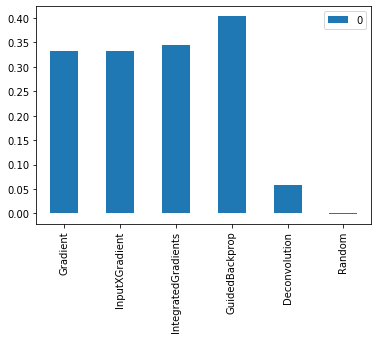

In [21]:
pd.DataFrame.from_dict(data_randomisation_result,orient='index').plot(kind='bar')